## File created by Reid Wyde


### Last updated 11.14.19



## todo:

doxorubicin needs to affect the entry of herceptin into the system, not its exit, or else group 3 will fit a high tau_dh and then groups 4 and 5 won't have enough herceptin to make a difference


# Data Driven Growth Models for Combination Therapy for HER2+ Breast Cancer

## Traversing differential equations parameter space using Markov Chain Monte Carlo

#### Background: Chemotherapy (Doxorubicin) and immunotherapy (Trastuzumab/Herceptin) were given to adult female rats previously injected with HER2+ breast cancer [ ]. Trastuzumab is understood to improve vascular regularization within tumors and improve chemotherapy efficacy [ ]. This project investigates growth models for HER2+ cancer in the presence of different combinations of Doxorubicin and Trastuzumab. The goal is to deliver a data validated growth model that informs optimal treatment using these therapies, as well as characterize the tumoral system, including the relationship between tumor size, natural growth rate, drug clearing rate, and magnitude of drug effect.

### Mathematical models of tumor growth and simulation visualizations provided by Dr. Ernesto Lima, Associate Researcher at The Center for Computational Oncology at The University of Texas, 2019. 

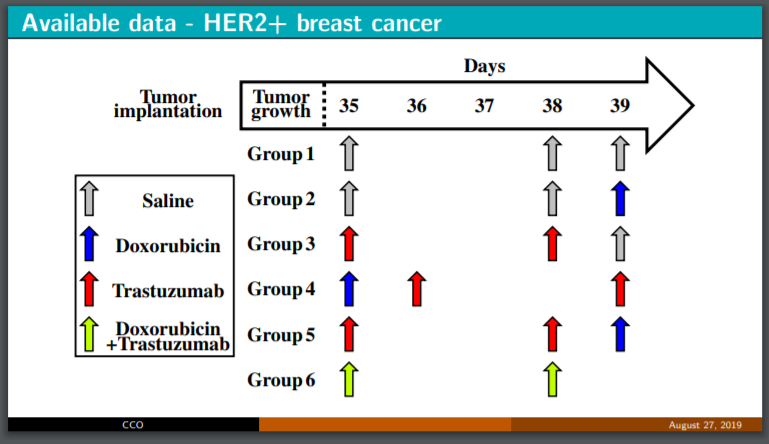

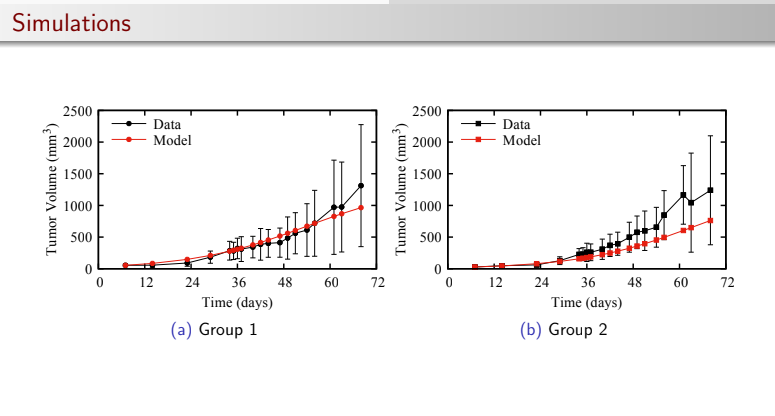

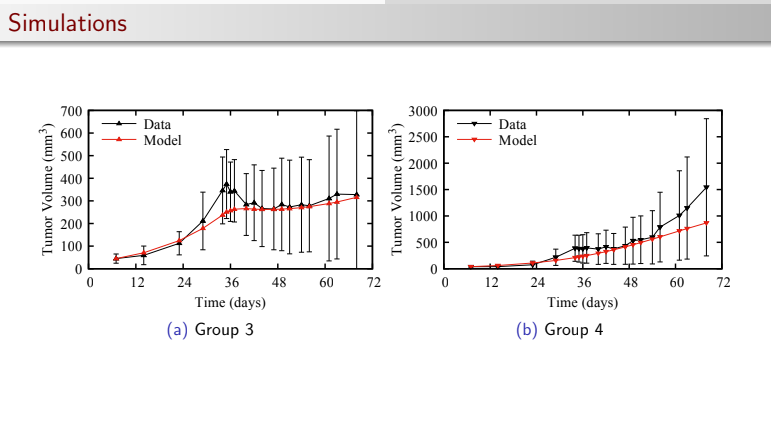

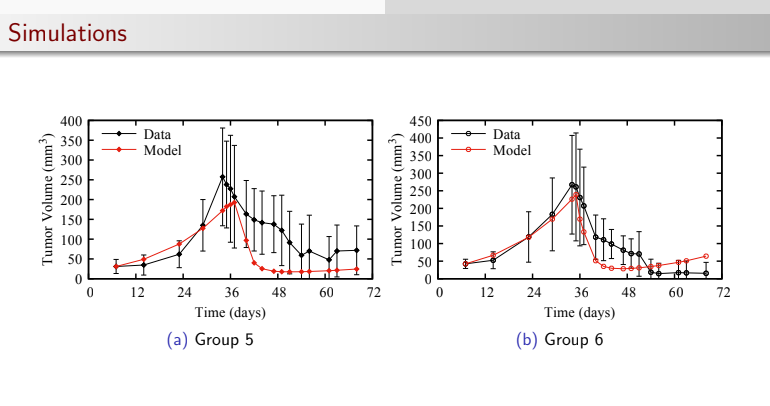

## Note: From here on, groups will be 0 indexed. i.e. group 0 is the control, group 5 is the simultaneous combination therapy

## General Strategy:  We will fit parameters one group at a time. Group 0 will parameterize the natural growth rate of cancer. Group 1 will parameterize Doxorubicin in isolation. Group 2 will parameterize Herceptin (Trastuzumab) in isolation. Groups 3, 4, and 5 will parameterize the drug-drug interaction. 


## This greedy strategy is motivated by the understanding that MCMC doesn't converge effectively for large dimensionality, models tend to get stuck. 

## New Model Iteration: Multiple Differential Equations

### Until now, we have considered the HER2+ cancer system as a single differential equation. We will now hypothesize that the system can be parameterized by multiple ODEs. 

### We will parameterize two different systems. The first system will be comprised of three differential equations. These equations will describe tumor growth, effective doxorubicin presence, and effective herceptin presence in the cancer system. 

### System 1:

$$ \frac{dT}{dt} = ( r - \delta_D D - \delta_{DH} D H - \delta_H H ) T  $$


$$ \frac{dH}{dt} = S_H - \tau_H H - \tau_{DH} D H $$


$$ \frac{dD}{dt} = S_D - \tau_D D
\;\;\;\;
or
\;\;\;\;
\frac{dD}{dt} = S_D - \tau_D D + \tau_{HD} H 
$$



With $S_h$ and $S_D$ being considered in this model as the Kronecker delta function, occuring $\epsilon$ time after the days of treatment listed, since those datapoints were taken before treatment was given on those days.


### system 3

Doxorubicin burns the trk family receptors, and thus prevents herceptin from entering or affecting the cell



$$ \frac{dT}{dt} = (r - \lambda_O O - \lambda_H H ) T $$


$$ \frac{dO}{dt} = \lambda_{OD} D + \lambda_{ODH} D H - \tau_O O $$


$$ \frac{dH}{dt} = \delta_He^{-\lambda_{HD}D} - \tau_H H $$


$$ \frac{dD}{dt} = \delta_D - \tau_D D
\;\;\;\;
or 
\;\;\;\;
\frac{dD}{dt} = \delta_D + \lambda_{DH} H - \tau_D D 
$$

With:


$ r $ The natural growth rate

$ \lambda_O $ The effect of ROS on the tumor 

$ \lambda_H $ The effect of Herceptin on the tumor (likely through immune signalling) 

$ \lambda_{OD} $ The effect of Doxorubicin on the number of ROS

$ \lambda_{ODH} $ The synergistic effect of Herceptin's NRF2 suppression and Doxorubicin's production of ROS

$ \lambda_{DH} $ Herceptin's suppression of NRF2 on Doxorubicin clearing rate 

$$
\;
\;
$$


$ \tau_O $ The natural clearing rate of ROS

$ \tau_H $ The natural clearing rate of Herceptin

$ \tau_D $ The natural clearing rate of Doxorubcin

$$
\;
\;
$$


$ \delta_H $ The Kronecker delta representing Herceptin drug delivery on the specified treatment days

$ \delta_D $ The Kronecker delta representing Doxorubicin drug delivery on the specified treatment days





# Code

#### If the imports fail, run the install_packages notebook

In [1]:
#!MKL_THREADING_LAYER=GNU

In [2]:
#visualization
import matplotlib.pyplot as plt

#arrays
import numpy as np

#file system
import os
import platform

#CSV read
import pandas as pd

#model building
import pymc3 as pm
import theano
import theano.tensor as tt
from theano.compile.ops import as_op

np.random.seed(123)

In [3]:
if platform.system() == 'Windows':  # check the file system formatting
    filtered_filename = os.getcwd() + '\..\data\\filtered_data_csv.csv'
else:
    filtered_filename = os.getcwd() + '/../data//filtered_data_csv.csv'
    
tumor_size_db = pd.read_csv(filtered_filename)
#tumor_size_db.head()

In [4]:
ts = np.array(tumor_size_db['Day']).transpose() # dimension: (19,)
Ts = np.array(tumor_size_db[['G1_avg','G2_avg','G3_avg','G4_avg','G5_avg','G6_avg']]).transpose() # indexing: group, time
sigmas = np.array(tumor_size_db[['G1_sd','G2_sd','G3_sd','G4_sd','G5_sd','G6_sd']]).transpose()

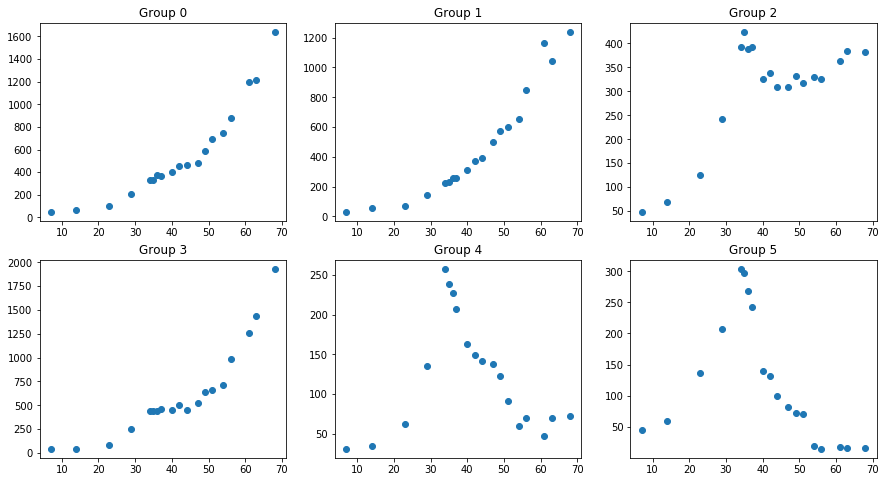

In [5]:
fig, axs = plt.subplots(2, 3, figsize=(15,8))
for group in range(6):
    axs[int(group/3), int(group%3)].title.set_text('Group ' + str(group))
    axs[int(group/3), int(group%3)].scatter(ts, Ts[group])
plt.show()

## Treatment model - Impulse

In [6]:
def get_tt(tuple_treatment_group):
    switcher={
        ('dox',1): [39],
        
        ('her',2): [35,38],
        
        ('dox',3): [35],
        ('her',3): [36,39],
        
        ('her',4): [35,38],
        ('dox',4): [39],
        
        ('her',5): [35,38],
        ('dox',5): [35,38]
    }  
    return switcher.get(tuple_treatment_group, [])

def get_Sd_impulse(ts):
    Sds = np.zeros((6, len(ts)))
    for group in range(6):
        treatment_times = get_tt(('dox', group))
        for tt in treatment_times:
            ii = np.where(ts > tt)[0][0]
            Sds[group, ii] = 1
    return Sds
    
def get_Sh_impulse(ts):
    Shs = np.zeros((6, len(ts)))
    for group in range(6):
        treatment_times = get_tt(('her', group))
        for tt in treatment_times:
            ii = np.where(ts > tt)[0][0]
            Shs[group, ii] = 1
    return Shs

def get_Sd_impulse_by_group(ts, group):
    Sds = np.zeros((1, len(ts)))
    treatment_times = get_tt(('dox', group))
    for tt in treatment_times:
        ii = np.where(ts > tt)[0][0]
        Sds[0, ii] = 1
    return Sds
    
def get_Sh_impulse_by_group(ts, group):
    Shs = np.zeros((1, len(ts)))
    treatment_times = get_tt(('her', group))
    for tt in treatment_times:
        ii = np.where(ts > tt)[0][0]
        Shs[0, ii] = 1
    return Shs

def get_Sd_impulse_Combination(ts, group_idxs):
    Sds = np.zeros((len(group_idxs), len(ts)))
    for ii in range(len(group_idxs)):
        group_idx = group_idxs[ii]
        treatment_times = get_tt(('dox', group_idx))
        for tt in treatment_times:
            jj = np.where(ts > tt)[0][0]
            Sds[ii, jj] = 1
    return Sds

def get_Sh_impulse_Combination(ts, group_idxs):
    Shs = np.zeros((len(group_idxs), len(ts)))
    for ii in range(len(group_idxs)):
        group_idx = group_idxs[ii]
        treatment_times = get_tt(('her', group_idx))
        for tt in treatment_times:
            jj = np.where(ts > tt)[0][0]
            Shs[ii, jj] = 1
    return Shs

### Treatment calculation unit tests

teatment impulse


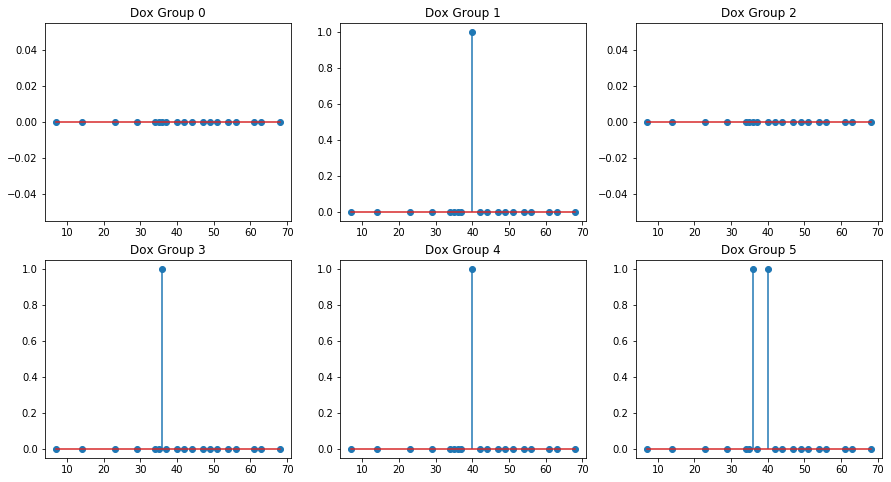

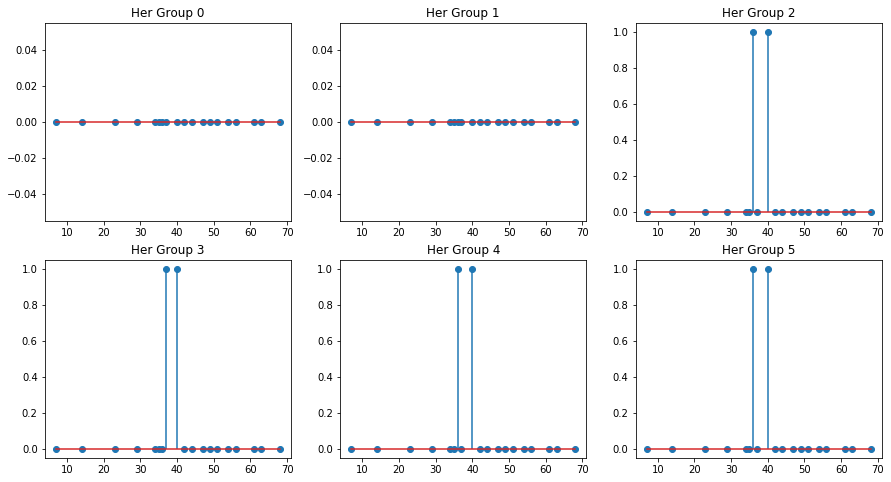

treatment impulse by group


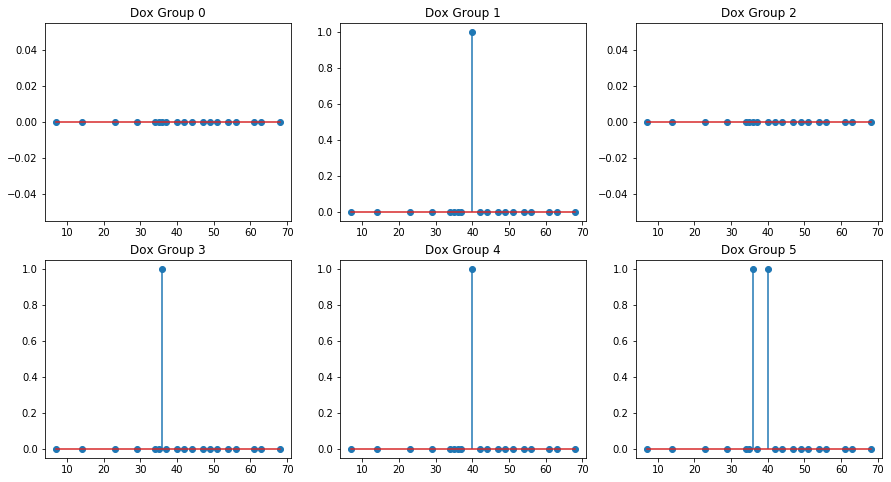

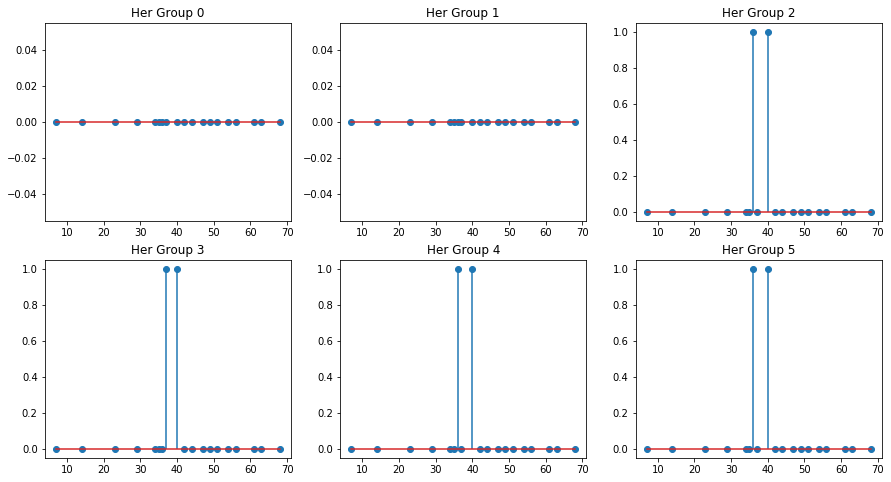

In [7]:
def test_treatment_Sd_impulse():
    tau_d=0.1
    Sds = get_Sd_impulse(ts)
    fig, axs = plt.subplots(2, 3, figsize=(15,8))
    for group in range(6):
        axs[int(group/3), int(group%3)].title.set_text('Dox Group ' + str(group))
        axs[int(group/3), int(group%3)].stem(ts, Sds[group], use_line_collection=True)
    plt.show()
    return

def test_treatment_Sh_impulse():
    Shs = get_Sh_impulse(ts)
    fig, axs = plt.subplots(2, 3, figsize=(15,8))
    for group in range(6):
        axs[int(group/3), int(group%3)].title.set_text('Her Group ' + str(group))
        axs[int(group/3), int(group%3)].stem(ts, Shs[group], use_line_collection=True)
    plt.show()
    return


def test_treatment_Sd_impulse_by_group():
    Sds = np.zeros((6, len(ts)))
    for group in range(6):
        Sds[group,:] = get_Sd_impulse_by_group(ts, group)
    fig, axs = plt.subplots(2, 3, figsize=(15,8))
    for group in range(6):
        axs[int(group/3), int(group%3)].title.set_text('Dox Group ' + str(group))
        axs[int(group/3), int(group%3)].stem(ts, Sds[group], use_line_collection=True)
    plt.show()
    return


def test_treatment_Sh_impulse_by_group():
    #ts = np.array([int(x) for x in np.linspace(0,99,100)])
    Ts = np.ones(ts.shape)
    Shs = np.zeros((6, len(ts)))
    for group in range(6):
        Shs[group,:] = get_Sh_impulse_by_group(ts, group)
    fig, axs = plt.subplots(2, 3, figsize=(15,8))
    for group in range(6):
        axs[int(group/3), int(group%3)].title.set_text('Her Group ' + str(group))
        axs[int(group/3), int(group%3)].stem(ts, Shs[group], use_line_collection=True)
    plt.show()
    return


print('teatment impulse')
test_treatment_Sd_impulse()
test_treatment_Sh_impulse()

print('treatment impulse by group')
test_treatment_Sd_impulse_by_group()
test_treatment_Sh_impulse_by_group()



## Simulation Graphing Methods

In [8]:
sim_times = np.linspace(7,70,100*(70-7+1)) # original time indexing started at day 7

def graph_sim_by_group(sim_times, T_sim, group):
    plt.figure(figsize=[4,2.5])
    plt.scatter(ts, Ts[group,:])
    plt.errorbar(ts, Ts[group,:], sigmas[group,:],fmt='.',capsize=2)
    plt.plot(sim_times, T_sim)
    plt.title('Group ' + str(group))
    plt.xlabel('Day')
    plt.ylabel('Size')
    plt.show()
    
def graph_sim(sim_times, T_sim):
    plt.figure(figsize=[16,10])
    for group in range(6):
        plt.subplot(2,3,group+1)
        plt.scatter(ts, Ts[group,:])
        plt.errorbar(ts, Ts[group,:], sigmas[group,:],fmt='.',capsize=2)
        plt.plot(sim_times, T_sim[group,:])
        plt.title('Group ' + str(group))
        plt.xlabel('Day')
        plt.ylabel('amt')
    plt.show()

## Forward DE Models

In [9]:
def rk_var_update(var, ks):
    k1, k2, k3, k4 = [x for x in ks]
    var = var + (1.0 / 6.0)*(k1 + 2 * k2 + 2 * k3 + k4)
    var[var<0] = 0
    return var

def rk_T(h, t0, T, H, O, params, j, dTdt):
    k1 = h * dTdt(t0, T, H, O, params, j) 
    k2 = h * dTdt(t0+0.5*h, T + 0.5 * k1, H, O, params, j) 
    k3 = h * dTdt(t0+0.5*h, T + 0.5 * k2, H, O, params, j) 
    k4 = h * dTdt(t0+h, T + k3, H, O, params, j)   
    return k1, k2, k3, k4

def rk_D(h, t0, D, params, j, dDdt):
    k1 = h * dDdt(t0, D, params, j) 
    k2 = h * dDdt(t0+0.5*h, D + 0.5 * k1, params, j) 
    k3 = h * dDdt(t0+0.5*h, D + 0.5 * k2, params, j) 
    k4 = h * dDdt(t0+h, D + k3, params, j)   
    return k1, k2, k3, k4
    
def rk_H(h, t0, H, D, params, j, dHdt):
    k1 = h * dHdt(t0, H, D, params, j) 
    k2 = h * dHdt(t0+0.5*h, H + 0.5 * k1, D, params, j) 
    k3 = h * dHdt(t0+0.5*h, H + 0.5 * k2, D, params, j) 
    k4 = h * dHdt(t0+h, H + k3, D, params, j) 
    return k1, k2, k3, k4

def rk_O(h, t0, O, D, H, params, j, dOdt):
    k1 = h * dOdt(t0, O, D, H, params, j) 
    k2 = h * dOdt(t0+0.5*h, O + 0.5 * k1, D, H, params, j) 
    k3 = h * dOdt(t0+0.5*h, O + 0.5 * k2, D, H, params, j) 
    k4 = h * dOdt(t0+h, O + k3, D, H, params, j)
    return k1, k2, k3, k4

def rungeKutta_all_params(ts, T0, dTdt, dDdt, dHdt, dOdt, Sds, Shs, params):
    time_len = len(ts.ravel())
    ret_T = np.zeros((T0.shape[0], time_len))
    ret_D = np.zeros(ret_T.shape)
    ret_H = np.zeros(ret_T.shape)
    ret_O = np.zeros(ret_T.shape)
    T = T0
    D = ret_D[:,0]
    H = ret_H[:,0]
    O = ret_O[:,0]
    ret_T[:, 0] = T0
    for i in range(1, time_len):
        t0 = ts[i-1]
        t = ts[i]
        h = t-t0
        Sd = Sds[:,i-1]
        Sh = Shs[:,i-1]

        D_new = rk_var_update(D, rk_D(h, t0, D, params, i-1, dDdt))
        H_new = rk_var_update(H, rk_H(h, t0, H, D, params, i-1, dHdt))
        O_new = rk_var_update(O, rk_O(h, t0, O, D, H, params, i-1, dOdt))
        T_new = rk_var_update(T, rk_T(h, t0, T, H, O, params, i-1, dTdt))
        
        D = D_new + Sd
        H = H_new + Sh
        O = O_new         
        T = T_new 
        
        ret_T[:,i] = T
        ret_D[:,i] = D
        ret_H[:,i] = H
        ret_O[:,i] = O
    
    return ret_T, ret_D, ret_H, ret_O


## Growth Model Class

In [10]:
class growth_model(object):
    def __init__(self, times, T0):
        self._times = times
        self._T0 = T0
        
    def dTdt(self, *argv):
        return 0
    def dDdt(self, *argv):
        return 0
    def dHdt(self, *argv):
        return 0
    def dOdt(self, *argv):
        return 0
   
    def get_param(self, param_name, n=10):
        return pm.summary(self.trace)['mean'][param_name]

## Logistic Growth Model
### Used to fit to group 0 data

$$ \frac{dT}{dt} = (r - \lambda_O O - \lambda_H H ) T $$


$$ \frac{dO}{dt} = \lambda_{OD} D + \lambda_{ODH} D H - \tau_O O $$


$$ \frac{dH}{dt} = \delta_He^{-\lambda_{HD}D} - \tau_H H $$


$$ \frac{dD}{dt} = \delta_D - \tau_D D
\;\;\;\;
or 
\;\;\;\;
\frac{dD}{dt} = \delta_D + \lambda_{DH} H - \tau_D D 
$$

Sequential sampling (3 chains in 1 job)
Metropolis: [r]
100%|█████████████████████████████████████████████████████████████████████████████| 1440/1440 [00:08<00:00, 177.72it/s]
The gelman-rubin statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.
C:\Users\Reid\Anaconda3\lib\site-packages\pymc3\stats.py:991: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  axis=1, join_axes=[dforg.index])


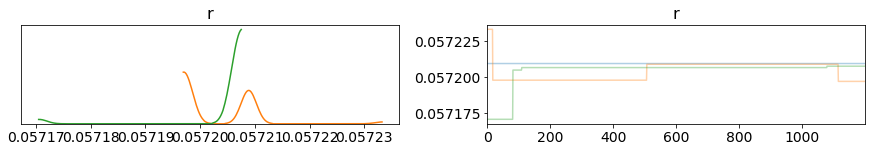

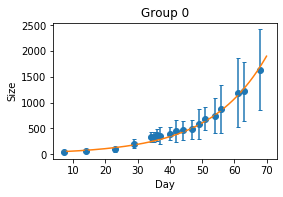

r: 0.05720578364719504


In [11]:
class growth_model_natural(growth_model):
    def __init__(self):
        super().__init__(ts, np.array(Ts[0,0]).reshape(-1,1))
        self.group_num = 0
        self._times = ts
        
        self.Sds_fit = get_Sd_impulse_by_group(ts, 0)
        self.Shs_fit = get_Sh_impulse_by_group(ts, 0)
        
        self.Sds_sim = get_Sd_impulse_by_group(sim_times, 0)
        self.Shs_sim = get_Sh_impulse_by_group(sim_times, 0)
        
        self.Sds = self.Sds_fit
        self.Shs = self.Shs_fit 
         
    def _simulate(self, params, times):
        T_values, _, _, _ = rungeKutta_all_params(times, self._T0, self.dTdt, self.dDdt, self.dHdt, self.dOdt, self.Sds, self.Shs, params)
        return T_values      
    
    def simulate(self, r, times=None):
        if times is None: times = self._times        
        return self._simulate([r], times)
    
    def dTdt(self, t, T, H, O, params, i):
        r = params[0]
        return T*r
    
    def backward(self):
        T_obs = Ts[0,:]
        sigmas_obs = np.ones(T_obs.shape)
        with pm.Model():
            self.param_list = ['r']
            r_lower = 0.0001
            r_upper = 0.1

            r = pm.Uniform('r', lower=r_lower, upper=r_upper)

            ## Theano wrapper is necessary in order to pass the forward evolution to PyMC3
            @as_op(itypes=[tt.dscalar], otypes=[tt.dmatrix]) 
            def th_forward_model(r):
                th_states = self.simulate(r)
                return th_states
            
            forward = th_forward_model(r)
            
            T = pm.Normal('T', mu=forward, sigma = sigmas_obs, observed=T_obs)

            # Initial points for each of the chains
            np.random.seed(100)
            n_chains = 3
            startsmc=[{'r':np.random.uniform(r_lower, r_upper),             
                      } for _ in range(n_chains)]
            num_samples = 1200 # Within each chain, operations are sequential and cannot be parallelized.
            num_tune = int(num_samples/5)
            step = pm.Metropolis()
            self.trace = pm.sample(num_samples, step=step, tune=num_tune, chains = n_chains, cores=1, start=startsmc)
            pm.traceplot(self.trace)
            
    def fit_sim_graph_model():
        this_model = growth_model_natural()
        this_model.backward()
        this_model.Sds = this_model.Sds_sim
        this_model.Shs = this_model.Shs_sim
        r = this_model.get_param('r')
        T_sim = this_model.simulate(r, sim_times)
        graph_sim_by_group(sim_times, T_sim.reshape(-1,1), 0)
        print('r: ' + str(r))

        return r


            
r = growth_model_natural.fit_sim_graph_model()

#r = 0.06
#K = 7161

## Herceptin Treatment

$$ \frac{dT}{dt} = (r - \lambda_O O - \lambda_H H ) T $$


$$ \frac{dO}{dt} = \lambda_{OD} D + \lambda_{ODH} D H - \tau_O O $$


$$ \frac{dH}{dt} = \delta_He^{-\lambda_{HD}D} - \tau_H H $$


$$ \frac{dD}{dt} = \delta_D - \tau_D D
\;\;\;\;
or 
\;\;\;\;
\frac{dD}{dt} = \delta_D + \lambda_{DH} H - \tau_D D 
$$

C:\Users\Reid\Anaconda3\lib\site-packages\ipykernel_launcher.py:133: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.


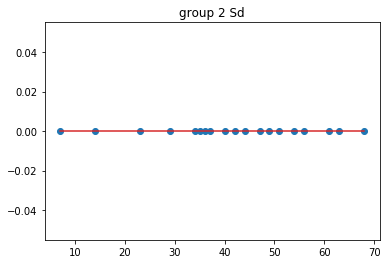

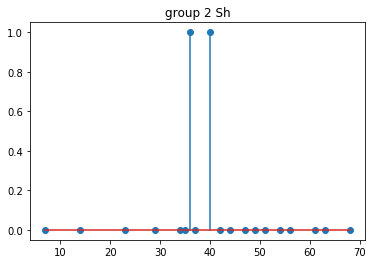

(1, 19)


Only 200 samples in chain.
Sequential sampling (5 chains in 1 job)
CompoundStep
>Metropolis: [tau_H]
>Metropolis: [lambda_H]
100%|████████████████████████████████████████████████████████████████████████████████| 240/240 [00:03<00:00, 64.31it/s]
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.
C:\Users\Reid\Anaconda3\lib\site-packages\pymc3\stats.py:991: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  axis=1, join_axes=[dforg.index])


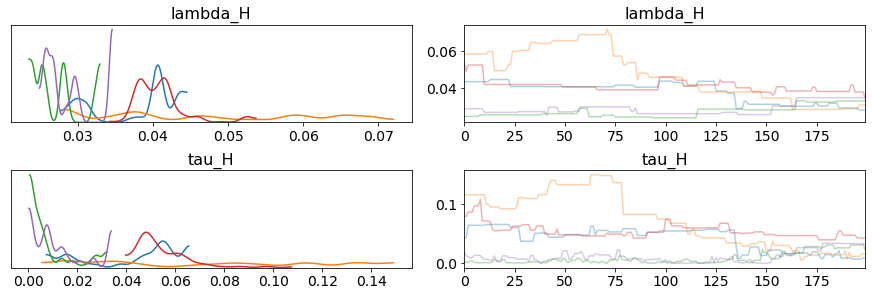

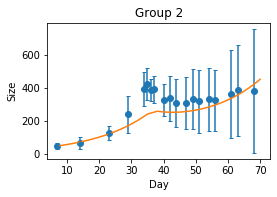

lambda_H: 0.03623117019302559
tau_H: 0.03772623228515419


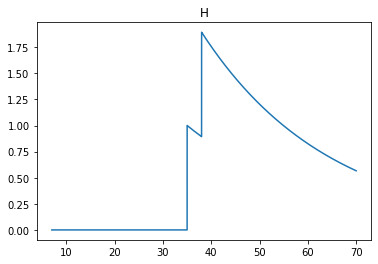

In [12]:
class growth_model_her(growth_model):
    def __init__(self):
        super().__init__(ts, np.array(Ts[2,0]).reshape(-1,1))
        self.group_num = 2
        self._times = ts
        
        self.Sds_fit = get_Sd_impulse_by_group(ts, 2)
        self.Shs_fit = get_Sh_impulse_by_group(ts, 2)
        
        self.Sds_sim = get_Sd_impulse_by_group(sim_times, 2)
        self.Shs_sim = get_Sh_impulse_by_group(sim_times, 2)
        
        self.Sds = self.Sds_fit
        self.Shs = self.Shs_fit 
         
        self.groups = [2]
        for ii in range(len(self.groups)):
            group = str(self.groups[ii])
            self.stem_short(ts, self.Sds[ii,:], 'group ' + group + ' Sd')
            self.stem_short(ts, self.Shs[ii,:], 'group ' + group + ' Sh')
            
        
    def _simulate(self, params, times):
        self.sim_T, self.sim_D, self.sim_H, self.sim_O = rungeKutta_all_params(times, \
                            self._T0, self.dTdt, self.dDdt, self.dHdt, self.dOdt, self.Sds, self.Shs, params)
        return self.sim_T
        
    def simulate(self, lambda_H, tau_H, times=None):
        if times is None: times = self._times
        return self._simulate([lambda_H, tau_H], times)
    
    def dHdt(self, t, H, D, params, Sh):
        lambda_H, tau_H = [x for x in params]
        #print('dHdt terms')
        #print(Sh)
        #print(tau_h)
        #print(H)
        return -tau_H*H
    
    
    def dDdt(self, t, D, params, i):
        return 0
        
    def dOdt(self, t, O, D, H, params, i):
        return 0
    
    def dTdt(self, t, T, H, O, params, i):
        lambda_H, tau_h  = [x for x in params] 
        return (r - lambda_H*H)*T
    
    def backward(self):
        T_obs = np.array(Ts[2,:]).reshape(1,-1)
        print(T_obs.shape)
        sigmas_obs = np.ones(T_obs.shape)*50
        self.param_list = ['lambda_H', 'tau_H']
        
        with pm.Model():
            lambda_H_lower = 0
            lambda_H_upper = 0.1            
            
            tau_H_lower = 0
            tau_H_upper = 0.3
            
            
            lambda_H = pm.Uniform('lambda_H', lower=lambda_H_lower, upper=lambda_H_upper)
            tau_H = pm.Uniform('tau_H', lower=tau_H_lower, upper=tau_H_upper)
            
            @as_op(itypes=[tt.dscalar, tt.dscalar], otypes=[tt.dmatrix]) 
            def th_forward_model(lambda_H, tau_H):
                th_states = self.simulate(lambda_H, tau_H)
                return th_states
            
            forward = th_forward_model(lambda_H, tau_H)
            
            T = pm.Normal('T', mu=forward, sigma = sigmas_obs, observed=T_obs)

            # Initial points for each of the chains
            np.random.seed(100)
            n_chains = 5
            startsmc=[{'tau_H':np.random.uniform(tau_H_lower, tau_H_upper), 
                       'lambda_H':np.random.uniform(lambda_H_lower, lambda_H_upper),
                      } for _ in range(n_chains)]
            num_samples = 200
            num_tune = int(num_samples/5)
            step = pm.Metropolis()
            self.trace = pm.sample(num_samples, step=step, tune=num_tune, chains = n_chains, cores=1, start=startsmc)
            pm.traceplot(self.trace) 
            
            
    def fit_sim_graph_model():
        this_model = growth_model_her()
        this_model.backward()
        this_model.Sds = this_model.Sds_sim
        this_model.Shs = this_model.Shs_sim
        lambda_H, tau_H = [this_model.get_param(x) for x in this_model.param_list]
        T_sim = this_model.simulate(lambda_H, tau_H, sim_times)
        graph_sim_by_group(sim_times, T_sim.reshape(-1,1), 2)
        print('lambda_H: ' + str(lambda_H))
        print('tau_H: ' + str(tau_H))
        
        this_model.plot_short(sim_times, this_model.sim_H, 'H')

        return lambda_H, tau_H
    

    
    def sim_graph_model():
        this_model = growth_model_her()
        #this_model.backward()
        #return
        #lambda_h, tau_h = [this_model.get_param(x) for x in this_model.param_list]
        this_model.Sds = this_model.Sds_sim
        this_model.Shs = this_model.Shs_sim
        lambda_H = 0.04
        tau_H = 0.05
        this_model.simulate(lambda_H, tau_H, sim_times)
        graph_sim_by_group(sim_times, this_model.sim_T.reshape(-1,1), 2)
        print('lambda_H: ' + str(lambda_H))
        print('tau_H: ' + str(tau_H))
        
        this_model.plot_short(sim_times, this_model.sim_H, 'H')
        
        return lambda_H, tau_H
    
    def plot_short(self, times, var, title):
        plt.figure()
        plt.plot(times.ravel(), var.ravel())
        plt.title(title)
        plt.show()
        
    def stem_short(self, times, var, title):
        plt.figure()
        plt.stem(times.ravel(), var.ravel())
        plt.title(title)
        plt.show()
    

            
lambda_H, tau_H = growth_model_her.fit_sim_graph_model()

#lambda_h, tau_h = growth_model_her.sim_graph_model()

## Combinational Therapy

$$ \frac{dT}{dt} = (r - \lambda_O O - \lambda_H H ) T $$


$$ \frac{dO}{dt} = \lambda_{OD} D + \lambda_{ODH} D H - \tau_O O $$


$$ \frac{dH}{dt} = \delta_He^{-\lambda_{HD}D} - \tau_H H $$


$$ \frac{dD}{dt} = \delta_D - \tau_D D
\;\;\;\;
or 
\;\;\;\;
\frac{dD}{dt} = \delta_D + \lambda_{DH} H - \tau_D D 
$$


lambda_O, lambda_OD, lambda_ODH, tau_O, lambda_HD, tau_D

In [13]:

def rungeKutta_all_params(ts, T0, dTdt, dDdt, dHdt, dOdt, Sds, Shs, params):
    lambda_O, lambda_OD, lambda_ODH, tau_O, lambda_HD, tau_D = [x for x in params]
    time_len = len(ts.ravel())
    ret_T = np.zeros((T0.shape[0], time_len))
    ret_D = np.zeros(ret_T.shape)
    ret_H = np.zeros(ret_T.shape)
    ret_O = np.zeros(ret_T.shape)
    T = T0
    D = ret_D[:,0]
    H = ret_H[:,0]
    O = ret_O[:,0]
    ret_T[:, 0] = T0
    for i in range(1, time_len):
        t0 = ts[i-1]
        t = ts[i]
        h = t-t0
        Sd = Sds[:,i-1]
        Sh = Shs[:,i-1]

        D_new = rk_var_update(D, rk_D(h, t0, D, params, i-1, dDdt)) + Sd
        H_new = rk_var_update(H, rk_H(h, t0, H, D, params, i-1, dHdt)) + Sh*np.exp(-lambda_HD*D)
        O_new = rk_var_update(O, rk_O(h, t0, O, D, H, params, i-1, dOdt))
        T_new = rk_var_update(T, rk_T(h, t0, T, H, O, params, i-1, dTdt))
        
        D = D_new
        H = H_new
        O = O_new         
        T = T_new 
        
        ret_T[:,i] = T
        ret_D[:,i] = D
        ret_H[:,i] = H
        ret_O[:,i] = O
    
    return ret_T, ret_D, ret_H, ret_O

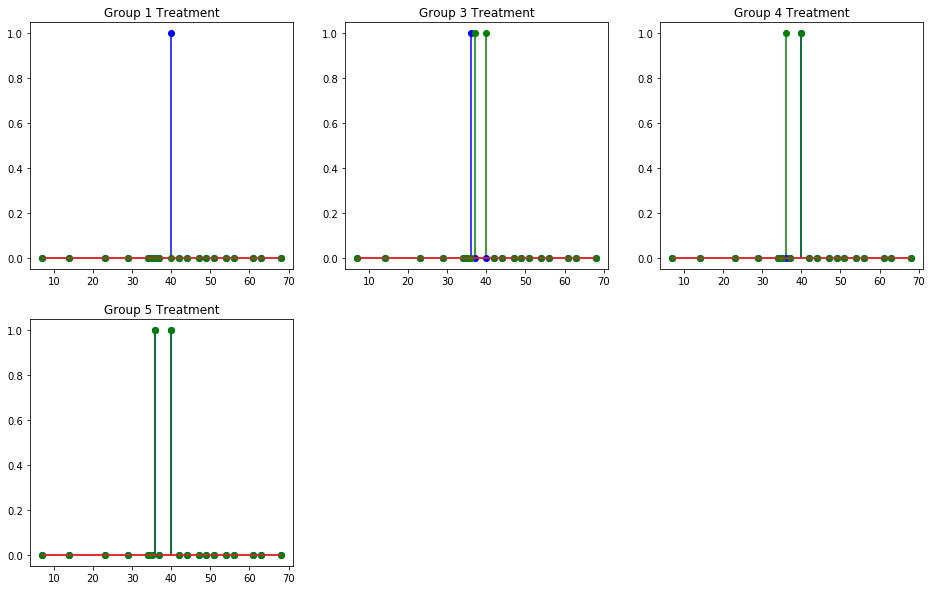

Only 50 samples in chain.
Sequential sampling (20 chains in 1 job)
CompoundStep
>Metropolis: [tau_D]
>Metropolis: [lambda_HD]
>Metropolis: [tau_O]
>Metropolis: [lambda_ODH]
>Metropolis: [lambda_OD]
>Metropolis: [lambda_O]
100%|██████████████████████████████████████████████████████████████████████████████████| 60/60 [00:03<00:00, 16.58it/s]
C:\Users\Reid\Anaconda3\lib\site-packages\pymc3\sampling.py:464: UserWarning: The number of samples is too small to check convergence reliably.
  warnings.warn("The number of samples is too small to check convergence reliably.")
C:\Users\Reid\Anaconda3\lib\site-packages\pymc3\stats.py:991: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  axis=1, join_axes=[dforg.index])


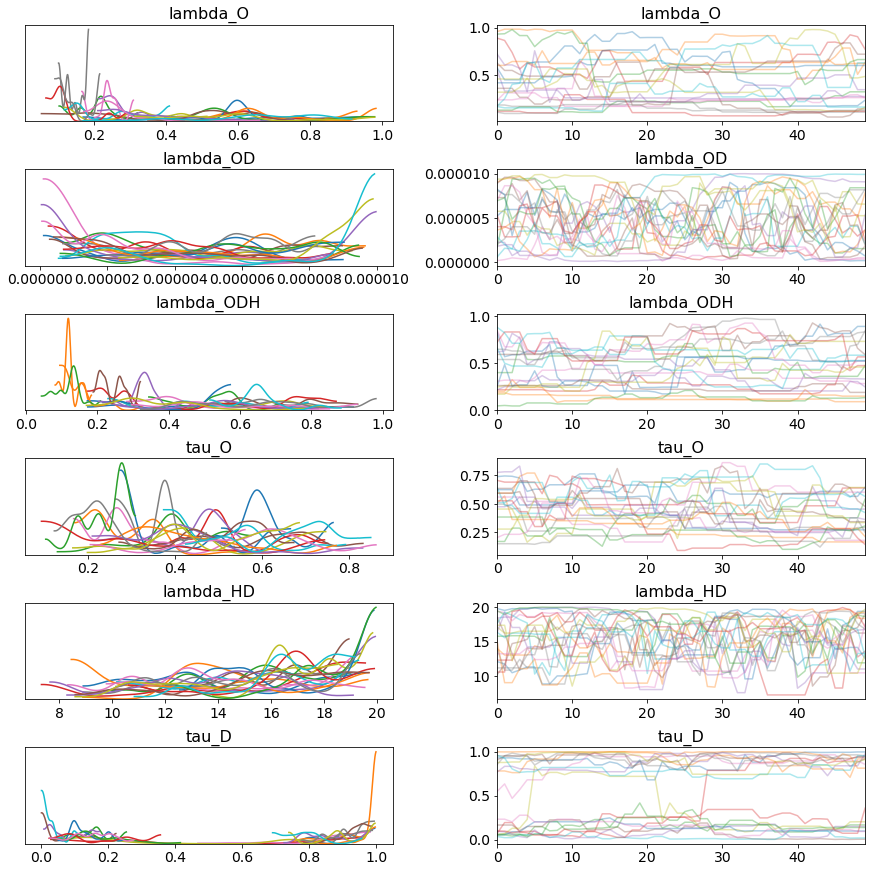

<Figure size 288x180 with 0 Axes>

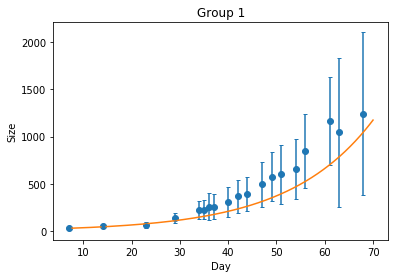

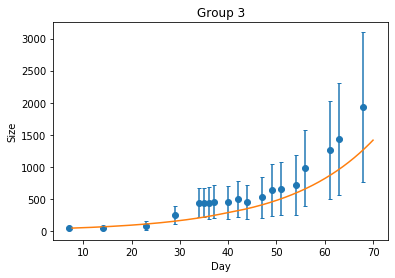

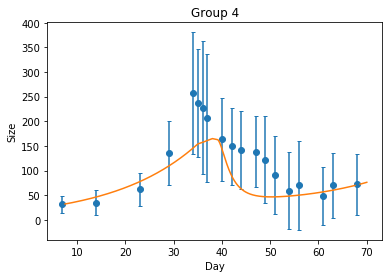

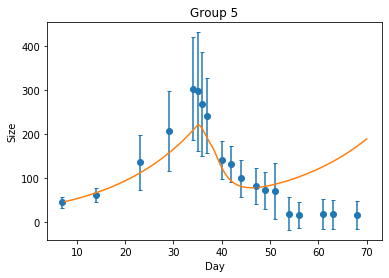

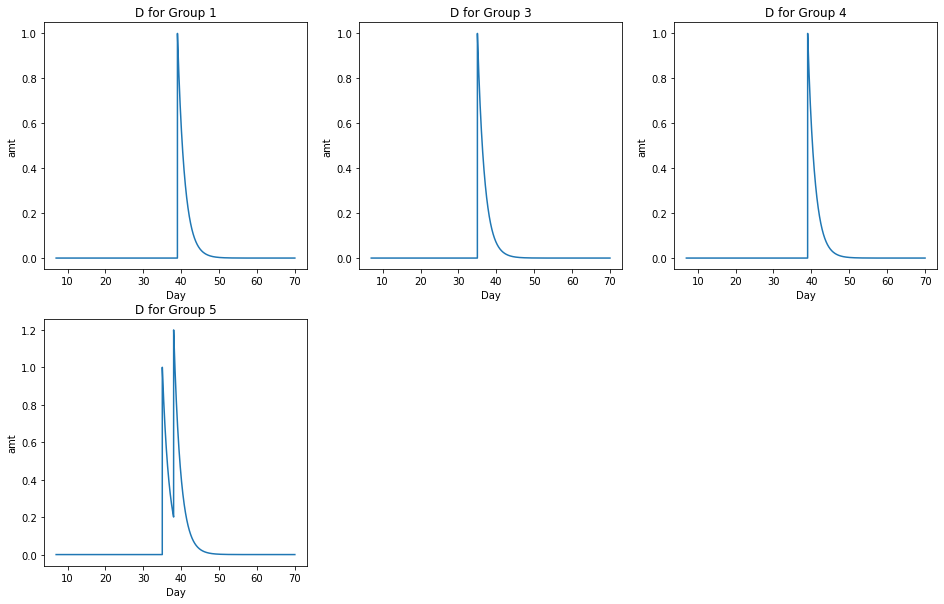

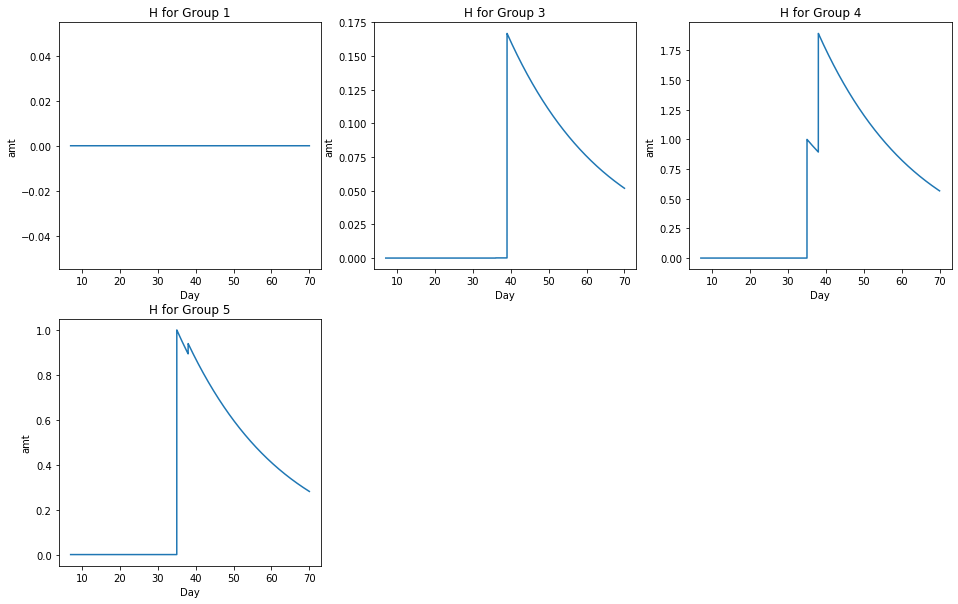

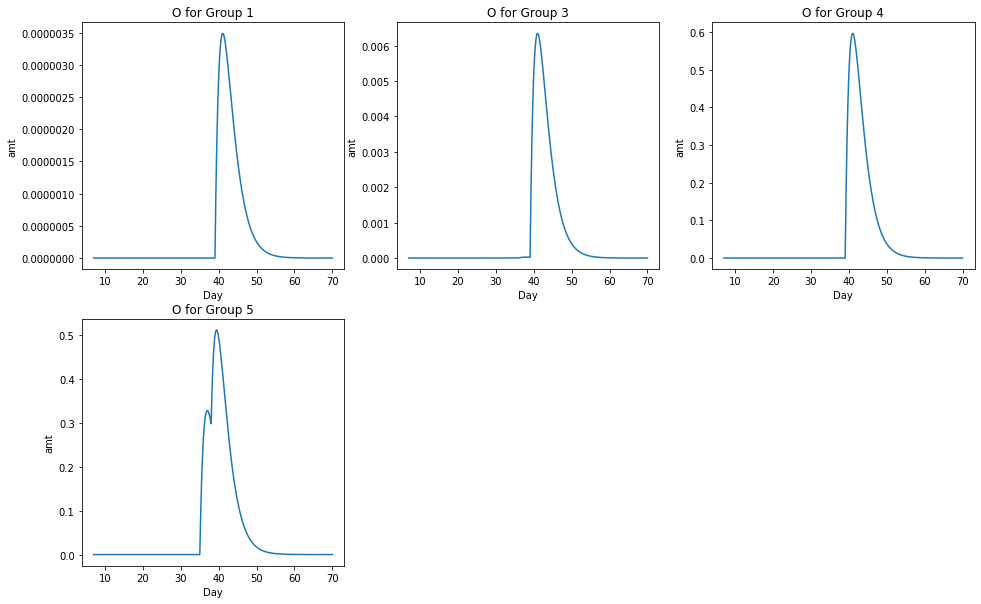

lambda_O: 0.4089645798782963
lambda_OD: 4.605228149756897e-06
lambda_ODH: 0.4482415225040386
tau_O: 0.4370763694550621
lambda_HD: 15.36215916215654
tau_D: 0.5388469137867787


In [14]:
class growth_model_dd_interaction(growth_model):
    
    def __init__(self):
        super().__init__(ts, np.concatenate(([Ts[1,0]],[Ts[3,0]],[Ts[4,0]],[Ts[5,0]]), axis=0))
        self.groups = [1,3,4,5]
        
        self.Sds_fit = get_Sd_impulse_Combination(ts, self.groups)
        self.Shs_fit = get_Sh_impulse_Combination(ts, self.groups)
        
        self.Sds_sim = get_Sd_impulse_Combination(sim_times, self.groups)
        self.Shs_sim = get_Sh_impulse_Combination(sim_times, self.groups)
        
        self.Sds = self.Sds_fit
        self.Shs = self.Shs_fit       
                   
        plt.figure(figsize=[16,10])
        for ii in range(len(self.groups)):
            group = self.groups[ii]
            plt.subplot(2,3,ii+1)
            plt.stem(ts, self.Sds[ii,:], 'b', markerfmt='bo', label='delta_D', use_line_collection=True)
            plt.stem(ts, self.Shs[ii,:], 'g', markerfmt='go', label='delta_H', use_line_collection=True)
            plt.title('Group ' + str(group) + ' Treatment')
        plt.show()
        
        
        
    def _simulate(self, params, times):
        self.sim_T, self.sim_D, self.sim_H, self.sim_O = rungeKutta_all_params(times, \
                            self._T0, self.dTdt, self.dDdt, self.dHdt, self.dOdt, self.Sds, self.Shs, params)
        return self.sim_T
    
    def simulate(self, lambda_O, lambda_OD, lambda_ODH, tau_O, lambda_HD, tau_D, times=None):
        if times is None: times = self._times        
        return self._simulate([lambda_O, lambda_OD, lambda_ODH, tau_O, lambda_HD, tau_D], times)
    
    def dDdt(self, t, D, params, i):
        lambda_O, lambda_OD, lambda_ODH, tau_O, lambda_HD, tau_D = [x for x in params]
        return -tau_D*D
    
    def dHdt(self, t, H, D, params, i):
        lambda_O, lambda_OD, lambda_ODH, tau_O, lambda_HD, tau_D = [x for x in params]
        return -tau_H*H
    
    def dOdt(self, t, O, D, H, params, i):
        lambda_O, lambda_OD, lambda_ODH, tau_O, lambda_HD, tau_D  = [x for x in params]
        return lambda_OD*D + lambda_ODH*D*H - tau_O*O
    
    def dTdt(self, t, T, H, O, params, i):
        lambda_O, lambda_OD, lambda_ODH, tau_O, lambda_HD, tau_D = [x for x in params]
        return (r - lambda_O*O - lambda_H*H)*T
    
    def backward(self):
        T_obs = Ts[self.groups,:]
        #sigmas_obs = sigmas[3:6,:]
        sigmas_obs = np.ones(T_obs.shape)*50
        
        with pm.Model():          
            self.param_list = ['lambda_O', 'lambda_OD', 'lambda_ODH', 'tau_O', 'lambda_HD', 'tau_D']
            
            
            lambda_O_lower = 0
            lambda_O_upper = 1
            
            lambda_OD_lower = 0
            lambda_OD_upper = 0.00001
            
            lambda_ODH_lower = 0
            lambda_ODH_upper = 1
            
            tau_O_lower = 0
            tau_O_upper = 1
            
            lambda_HD_lower = 0
            lambda_HD_upper = 20
            
            tau_D_lower = 0 
            tau_D_upper = 1
            
            lambda_O = pm.Uniform('lambda_O', lower= lambda_O_lower, upper= lambda_O_upper)
            lambda_OD = pm.Uniform('lambda_OD', lower= lambda_OD_lower, upper= lambda_OD_upper)
            lambda_ODH = pm.Uniform('lambda_ODH', lower= lambda_ODH_lower, upper= lambda_ODH_upper)
            tau_O = pm.Uniform('tau_O', lower= tau_O_lower, upper =tau_O_upper)
            lambda_HD = pm.Uniform('lambda_HD', lower= lambda_HD_lower, upper= lambda_HD_upper)
            tau_D = pm.Uniform('tau_D', lower= tau_D_lower, upper= tau_D_upper)
            
            @as_op(itypes=[tt.dscalar, tt.dscalar, tt.dscalar, tt.dscalar, tt.dscalar, tt.dscalar], otypes=[tt.dmatrix]) 
            def th_forward_model(lambda_O, lambda_OD, lambda_ODH, tau_O, lambda_HD, tau_D):
                th_states = self.simulate(lambda_O, lambda_OD, lambda_ODH, tau_O, lambda_HD, tau_D)
                return th_states
            
            forward = th_forward_model(lambda_O, lambda_OD, lambda_ODH, tau_O, lambda_HD, tau_D)
            
            T = pm.Normal('T', mu=forward, sigma = sigmas_obs, observed=T_obs)

            # Initial points for each of the chains
            np.random.seed(123)
            n_chains = 20
            startsmc=[{'lambda_O':np.random.uniform(lambda_O_lower, lambda_O_upper),
                       'lambda_OD':np.random.uniform(lambda_OD_lower, lambda_OD_upper),
                       'lambda_ODH':np.random.uniform(lambda_ODH_lower, lambda_ODH_upper),
                       'tau_O':np.random.uniform(tau_O_lower, tau_O_upper),
                       'lambda_HD':np.random.uniform(lambda_HD_lower, lambda_HD_upper),
                       'tau_D':np.random.uniform(tau_D_lower, tau_D_upper),
                      } for _ in range(n_chains)]
            num_samples = 50
            num_tune = int(num_samples/5)
            #step = pm.Slice()
            step = pm.Metropolis()
            self.trace = pm.sample(num_samples, step=step, tune=num_tune, chains = n_chains, cores=1, start=startsmc)
            pm.traceplot(self.trace)
            
            
    def plot_short(self, times, var, title):
        plt.figure()
        plt.plot(times.ravel(), var.ravel())
        plt.title(title)
        plt.show()
        
    def stem_short(self, times, var, title):
        plt.figure()
        plt.stem(times.ravel(), var.ravel())
        plt.title(title)
        plt.show()
                
    def graph_sims(self, sim_times, T_sim):
        plt.figure(figsize=[4,2.5])
        for ii in range(len(self.groups)):
            group = self.groups[ii]
            plt.figure()
            plt.scatter(ts, Ts[group,:])
            plt.errorbar(ts, Ts[group,:], sigmas[group,:],fmt='.', capsize=2)
            plt.plot(sim_times, T_sim[ii,:])
            plt.title('Group ' + str(group))
            plt.xlabel('Day')
            plt.ylabel('Size')
            plt.show()
            
        self.sim_D, self.sim_H, self.sim_O 
            
                
    def graph_Sds(self, times):
        plt.figure(figsize=[4,2.5])
        for ii in range(len(self.groups)):
            plt.figure()
            group = self.groups[ii]
            plt.stem(times, self.Sds[ii, :])
            plt.title('Group ' + str(group) + ' Sd')
            plt.xlabel('Day')
            plt.ylabel('Size')
            plt.show()
    
    def graph_Shs(self, times):
        plt.figure(figsize=[4,2.5])
        for ii in range(len(self.groups)):
            plt.figure()
            group = self.groups[ii]
            plt.stem(times, self.Shs[ii, :])
            plt.title('Group ' + str(group) + ' Sh')
            plt.xlabel('Day')
            plt.ylabel('Size')
            plt.show()
            
    def graph_D(self, sim_times):
        plt.figure(figsize=[16,10])
        for ii in range(len(self.groups)):
            group = self.groups[ii]
            plt.subplot(2,3,ii+1)
            plt.plot(sim_times, self.sim_D[ii,:])
            plt.title('D for Group ' + str(group))
            plt.xlabel('Day')
            plt.ylabel('amt')
        plt.show()
        
    def graph_H(self, sim_times):
        plt.figure(figsize=[16,10])
        for ii in range(len(self.groups)):
            group = self.groups[ii]
            plt.subplot(2,3,ii+1)
            plt.plot(sim_times, self.sim_H[ii,:])
            plt.title('H for Group ' + str(group))
            plt.xlabel('Day')
            plt.ylabel('amt')
        plt.show()
        
    def graph_O(self, sim_times):
        plt.figure(figsize=[16,10])
        for ii in range(len(self.groups)):
            group = self.groups[ii]
            plt.subplot(2,3,ii+1)
            plt.plot(sim_times, self.sim_O[ii,:])
            plt.title('O for Group ' + str(group))
            plt.xlabel('Day')
            plt.ylabel('amt')
        plt.show()
    
    
    def fit_sim_graph_model():
        this_model = growth_model_dd_interaction()
        this_model.backward()
        
        lambda_O, lambda_OD, lambda_ODH, tau_O, lambda_HD, tau_D = [this_model.get_param(x) for x in this_model.param_list]
        this_model.Sds = this_model.Sds_sim
        this_model.Shs = this_model.Shs_sim
        
        T_sim = this_model.simulate(lambda_O, lambda_OD, lambda_ODH, tau_O, lambda_HD, tau_D, sim_times)
        this_model.graph_sims(sim_times, T_sim)
        this_model.graph_D(sim_times)
        this_model.graph_H(sim_times)
        this_model.graph_O(sim_times)

        print('lambda_O: ' + str(lambda_O))      
        print('lambda_OD: ' + str(lambda_OD))   
        print('lambda_ODH: ' + str(lambda_ODH))
        print('tau_O: ' + str(tau_O))
        print('lambda_HD: ' + str(lambda_HD)) 
        print('tau_D: ' + str(tau_D))
                
        return lambda_O, lambda_OD, lambda_ODH, tau_O, lambda_HD, tau_D
    
    
    def sim_graph_model():
        this_model = growth_model_dd_interaction()
        this_model.Sds = this_model.Sds_sim
        this_model.Shs = this_model.Shs_sim
        
        lambda_O = 0.5
        lambda_OD = 0.5
        lambda_ODH = 0.5
        tau_O = 0.5
        lambda_HD = 0.5
        tau_D = 0.5
        
        T_sim = this_model.simulate(lambda_O, lambda_OD, lambda_ODH, tau_O, lambda_HD, tau_D, sim_times)
        
        this_model.graph_sims(sim_times, T_sim)
        this_model.graph_D(sim_times)
        this_model.graph_H(sim_times)
        this_model.graph_O(sim_times)
        
        
        print('lambda_O: ' + str(lambda_O))      
        print('lambda_OD: ' + str(lambda_OD))   
        print('lambda_ODH: ' + str(lambda_ODH))
        print('tau_O: ' + str(tau_O))
        print('lambda_HD: ' + str(lambda_HD)) 
        print('tau_D: ' + str(tau_D))

        return lambda_O, lambda_OD, lambda_ODH, tau_O, lambda_HD, tau_D
    
            
lambda_O, lambda_OD, lambda_ODH, tau_O, lambda_HD, tau_D = growth_model_dd_interaction.fit_sim_graph_model()
#lambda_O, lambda_OD, lambda_ODH, tau_O, lambda_HD, tau_D  = growth_model_dd_interaction.sim_graph_model()


## System 4

$$ \frac{dT}{dt} = (r - \lambda_O O) T $$


$$ \frac{dO}{dt} = \lambda_{OH} H + \lambda_{ODH} D H - \tau_O O $$


$$ \frac{dH}{dt} = \delta_He^{-\lambda_{HD}D} - \tau_H H $$


$$ \frac{dD}{dt} = \delta_D - \tau_D D $$


herc 

lambda_O, tau_O, lambda_OH, tau_H

C:\Users\Reid\Anaconda3\lib\site-packages\ipykernel_launcher.py:201: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.


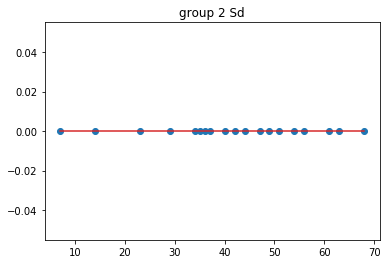

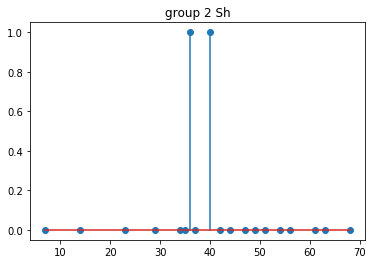

(1, 19)


Only 20 samples in chain.
Sequential sampling (20 chains in 1 job)
CompoundStep
>Metropolis: [tau_H]
>Metropolis: [lambda_OH]
>Metropolis: [tau_O]
>Metropolis: [lambda_O]
100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [00:00<00:00, 26.83it/s]
C:\Users\Reid\Anaconda3\lib\site-packages\pymc3\sampling.py:464: UserWarning: The number of samples is too small to check convergence reliably.
  warnings.warn("The number of samples is too small to check convergence reliably.")
C:\Users\Reid\Anaconda3\lib\site-packages\pymc3\stats.py:991: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  axis=1, join_axes=[dforg.index])


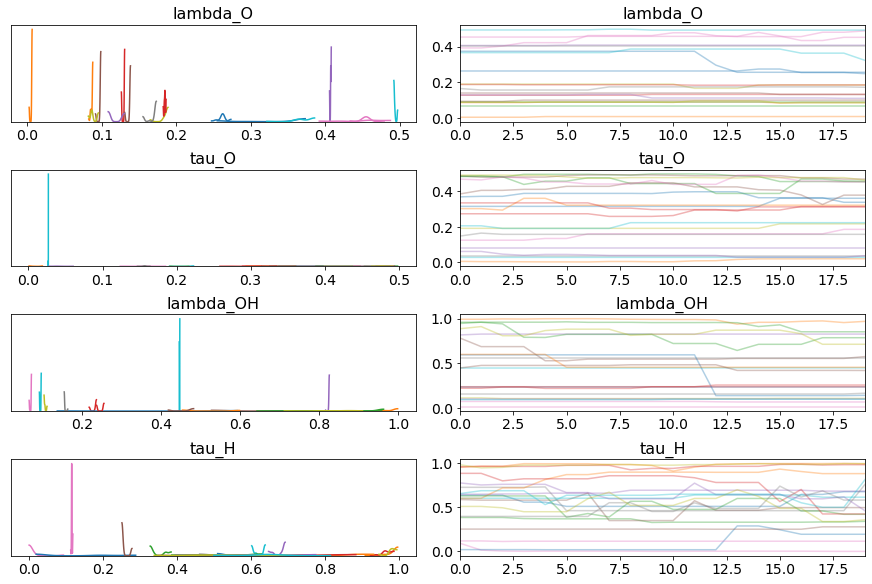

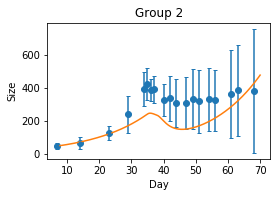

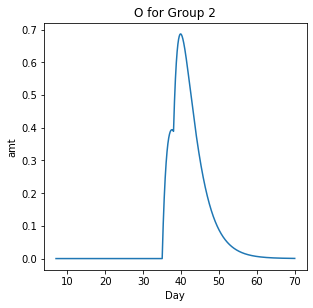

lambda_O: 0.22606591031667628
tau_O: 0.2646252800317971
lambda_OH: 0.42723147676796686
tau_H: 0.5531671541492923


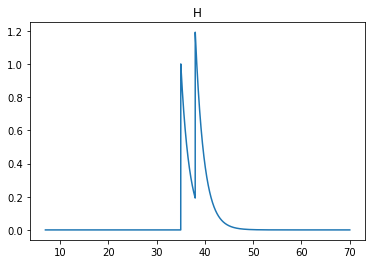

In [27]:
def rungeKutta_all_params(ts, T0, dTdt, dDdt, dHdt, dOdt, Sds, Shs, params):
    lambda_O, tau_O, lambda_OH, tau_H = [x for x in params]
    time_len = len(ts.ravel())
    ret_T = np.zeros((T0.shape[0], time_len))
    ret_D = np.zeros(ret_T.shape)
    ret_H = np.zeros(ret_T.shape)
    ret_O = np.zeros(ret_T.shape)
    T = T0
    D = ret_D[:,0]
    H = ret_H[:,0]
    O = ret_O[:,0]
    ret_T[:, 0] = T0
    for i in range(1, time_len):
        t0 = ts[i-1]
        t = ts[i]
        h = t-t0
        Sd = Sds[:,i-1]
        Sh = Shs[:,i-1]

        D_new = rk_var_update(D, rk_D(h, t0, D, params, i-1, dDdt)) + Sd
        H_new = rk_var_update(H, rk_H(h, t0, H, D, params, i-1, dHdt)) + Sh*np.exp(-lambda_HD*D)
        O_new = rk_var_update(O, rk_O(h, t0, O, D, H, params, i-1, dOdt))
        T_new = rk_var_update(T, rk_T(h, t0, T, H, O, params, i-1, dTdt))
        
        D = D_new
        H = H_new
        O = O_new         
        T = T_new 
        
        ret_T[:,i] = T
        ret_D[:,i] = D
        ret_H[:,i] = H
        ret_O[:,i] = O
    
    return ret_T, ret_D, ret_H, ret_O

class growth_model_her(growth_model):
    def __init__(self):
        super().__init__(ts, np.array(Ts[2,0]).reshape(-1,1))
        self.group_num = 2
        self._times = ts
        
        self.Sds_fit = get_Sd_impulse_by_group(ts, 2)
        self.Shs_fit = get_Sh_impulse_by_group(ts, 2)
        
        self.Sds_sim = get_Sd_impulse_by_group(sim_times, 2)
        self.Shs_sim = get_Sh_impulse_by_group(sim_times, 2)
        
        self.Sds = self.Sds_fit
        self.Shs = self.Shs_fit 
         
        self.groups = [2]
        for ii in range(len(self.groups)):
            group = str(self.groups[ii])
            self.stem_short(ts, self.Sds[ii,:], 'group ' + group + ' Sd')
            self.stem_short(ts, self.Shs[ii,:], 'group ' + group + ' Sh')
            
        
    def _simulate(self, params, times):
        self.sim_T, self.sim_D, self.sim_H, self.sim_O = rungeKutta_all_params(times, \
                            self._T0, self.dTdt, self.dDdt, self.dHdt, self.dOdt, self.Sds, self.Shs, params)
        return self.sim_T
        
    def simulate(self, lambda_O, tau_O, lambda_OH, tau_H, times=None):
        if times is None: times = self._times
        return self._simulate([lambda_O, tau_O, lambda_OH, tau_H], times)
    
    def dHdt(self, t, H, D, params, Sh):
        lambda_O, tau_O, lambda_OH, tau_H = [x for x in params]
        #print('dHdt terms')
        #print(Sh)
        #print(tau_h)
        #print(H)
        return -tau_H*H
    
    
    def dDdt(self, t, D, params, i):
        return 0
        
    def dOdt(self, t, O, D, H, params, i):
        lambda_O, tau_O, lambda_OH, tau_H = [x for x in params]
        return lambda_OH * H - tau_O * O
    
    def dTdt(self, t, T, H, O, params, i):
        lambda_O, tau_O, lambda_OH, tau_H = [x for x in params] 
        return (r - lambda_O*O)*T
    
    def backward(self):
        T_obs = np.array(Ts[2,:]).reshape(1,-1)
        print(T_obs.shape)
        sigmas_obs = np.ones(T_obs.shape)*50
        self.param_list = ['lambda_O', 'tau_O', 'lambda_OH', 'tau_H']
        
        with pm.Model():
            
            lambda_O_lower = 0
            lambda_O_upper = 0.5
            
            tau_O_lower = 0
            tau_O_upper = 0.5
            
            lambda_OH_lower = 0 
            lambda_OH_upper = 1
           
            tau_H_lower = 0
            tau_H_upper = 1
            
                      
            lambda_O = pm.Uniform('lambda_O', lower=lambda_O_lower, upper=lambda_O_upper)
            tau_O = pm.Uniform('tau_O', lower=tau_O_lower, upper=tau_O_upper)
            lambda_OH = pm.Uniform('lambda_OH', lower=lambda_OH_lower, upper=lambda_OH_upper)
            tau_H = pm.Uniform('tau_H', lower=tau_H_lower, upper=tau_H_upper)
            
            @as_op(itypes=[tt.dscalar, tt.dscalar, tt.dscalar, tt.dscalar], otypes=[tt.dmatrix]) 
            def th_forward_model(lambda_O, tau_O, lambda_OH, tau_H ):
                th_states = self.simulate(lambda_O, tau_O, lambda_OH, tau_H )
                return th_states
            
            forward = th_forward_model(lambda_O, tau_O, lambda_OH, tau_H)
            
            T = pm.Normal('T', mu=forward, sigma = sigmas_obs, observed=T_obs)
            # Initial points for each of the chains
            np.random.seed(100)
            n_chains = 20
            startsmc=[{'lambda_O':np.random.uniform(lambda_O_lower,lambda_O_upper),
                       'tau_O':np.random.uniform(tau_O_lower,tau_O_upper),
                       'lambda_OH':np.random.uniform(lambda_OH_lower,lambda_OH_upper),
                       'tau_H':np.random.uniform(tau_H_lower,tau_H_upper),
                      } for _ in range(n_chains)]
            num_samples = 20
            num_tune = int(num_samples/5)
            step = pm.Metropolis()
            self.trace = pm.sample(num_samples, step=step, tune=num_tune, chains = n_chains, cores=1, start=startsmc)
            pm.traceplot(self.trace) 
            
                
    def graph_O(self, sim_times):
        plt.figure(figsize=[16,10])
        for ii in range(len(self.groups)):
            group = self.groups[ii]
            plt.subplot(2,3,ii+1)
            plt.plot(sim_times, self.sim_O[ii,:])
            plt.title('O for Group ' + str(group))
            plt.xlabel('Day')
            plt.ylabel('amt')
        plt.show()
        
    def fit_sim_graph_model():
        this_model = growth_model_her()
        this_model.backward()
        this_model.Sds = this_model.Sds_sim
        this_model.Shs = this_model.Shs_sim
        lambda_O, tau_O, lambda_OH, tau_H = [this_model.get_param(x) for x in this_model.param_list]
        T_sim = this_model.simulate(lambda_O, tau_O, lambda_OH, tau_H, sim_times)
        graph_sim_by_group(sim_times, T_sim.reshape(-1,1), 2)
        this_model.graph_O(sim_times)
        
        print('lambda_O: ' + str(lambda_O))
        print('tau_O: ' + str(tau_O))
        print('lambda_OH: ' + str(lambda_OH))
        print('tau_H: ' + str(tau_H))
            
        this_model.plot_short(sim_times, this_model.sim_H, 'H')

        return lambda_O, tau_O, lambda_OH, tau_H 
    
    def sim_graph_model():
        this_model = growth_model_her()
        #this_model.backward()
        #return
        #lambda_h, tau_h = [this_model.get_param(x) for x in this_model.param_list]
        this_model.Sds = this_model.Sds_sim
        this_model.Shs = this_model.Shs_sim
        lambda_O = 0.5
        tau_O = 0.5
        lambda_OH = 0.5
        tau_H = 0.5
        
        this_model.simulate(lambda_O, tau_O, lambda_OH, tau_H, sim_times)
        
        graph_sim_by_group(sim_times, this_model.sim_T.reshape(-1,1), 2)
        this_model.graph_O(sim_times)
        
        print('lambda_O: ' + str(lambda_O))
        print('tau_O: ' + str(tau_O))
        print('lambda_OH: ' + str(lambda_OH))
        print('tau_H: ' + str(tau_H))
        
        this_model.plot_short(sim_times, this_model.sim_H, 'H')
        
        return lambda_O, tau_O, lambda_OH, tau_H
    
    def plot_short(self, times, var, title):
        plt.figure()
        plt.plot(times.ravel(), var.ravel())
        plt.title(title)
        plt.show()
        
    def stem_short(self, times, var, title):
        plt.figure()
        plt.stem(times.ravel(), var.ravel())
        plt.title(title)
        plt.show()
    

            
lambda_O, tau_O, lambda_OH, tau_H = growth_model_her.fit_sim_graph_model()

#lambda_O, tau_O, lambda_OH, tau_H = growth_model_her.sim_graph_model()

## Simulate parameters found by Dr. Lima



$$ \frac{dT}{dt} = (r - \lambda_O O) T $$


$$ \frac{dO}{dt} = \lambda_{OH} H + \lambda_{ODH} D H - \tau_O O $$


$$ \frac{dH}{dt} = \delta_He^{-\lambda_{HD}D} - \tau_H H $$


$$ \frac{dD}{dt} = \delta_D - \tau_D D $$


combination

lambda_ODH, lambda_HD, tau_D


Dr. Lima's Parameters

r = 6.773495e-02
k = 1.331254e+03
delta_h = 3.165840e-02
tau_h = 1.696031e-02
delta_d = 6.548050e-05
tau_d = 3.001805e-01
delta_dh = 4.327301e-01
tau_dh = 9.344758e+03




New Params

